In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data_finnal_12_lead.csv")
df.drop(columns=["Unnamed: 0"],inplace=True)
df

,FileName,Rhythm,PatientAge,Gender,Rcount_lead1,RRInterval_mean_lead1,RRInterval_median_lead1,RRInterval_std_lead1,RRInterval_range_lead1,RRInterval_skew_lead1,...,Rcount_lead12,RRInterval_mean_lead12,RRInterval_median_lead12,RRInterval_std_lead12,RRInterval_range_lead12,RRInterval_skew_lead12,RRInterval_kurtosis_lead12,R_peaks_amplitude_from_isoelectric_mean_lead12,PRovercount_lead12,medianOfRInterSubMedianOfPInter_lead12
0,MUSE_20180113_171327_27000,0,85,1,14.0,709.230769,540.0,455.907911,1626.0,2.299685,...,19.0,512.444444,532.0,69.325498,260.0,-0.212461,-0.180702,622.917926,0.631579,60.0
1,MUSE_20180112_073319_29000,1,59,0,8.0,1160.571429,1148.0,26.462141,68.0,0.249879,...,8.0,1160.857143,1148.0,26.680269,68.0,0.230522,-1.706863,737.646851,1.000000,4.0
2,MUSE_20180111_165520_97000,2,20,0,11.0,898.800000,891.0,52.032298,154.0,-0.110608,...,11.0,899.000000,893.0,52.124850,154.0,-0.142739,-1.353505,483.733038,1.000000,-35.0
3,MUSE_20180113_121940_44000,1,66,1,9.0,1125.500000,1131.0,15.419144,42.0,-0.551365,...,9.0,1125.750000,1132.0,16.686447,46.0,-0.602255,-1.189500,1229.775089,1.000000,21.0
4,MUSE_20180112_120347_79000,1,46,0,9.0,1059.750000,1065.0,23.333185,64.0,-0.521012,...,9.0,1059.750000,1066.0,23.290288,64.0,-0.573407,-1.154060,934.189646,1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9671,MUSE_20180712_151718_88000,3,65,1,13.0,774.500000,598.0,653.429478,2402.0,2.151993,...,14.0,590.461538,600.0,177.343047,780.0,0.975939,2.616653,486.754585,0.928571,4.0
9672,MUSE_20180712_151721_02000,3,55,0,21.0,457.300000,456.0,2.984962,10.0,0.159949,...,21.0,457.400000,456.0,2.973214,10.0,0.613624,-0.682746,462.674633,0.761905,-2.0
9673,MUSE_20180712_151744_19000,3,54,1,17.0,576.250000,594.0,48.522546,152.0,-2.258661,...,17.0,595.125000,594.0,2.642797,8.0,0.514886,-0.876387,300.997929,1.000000,-1.0
9674,MUSE_20180712_151746_33000,3,54,1,23.0,425.272727,426.0,5.832369,18.0,-0.111517,...,23.0,425.090909,426.0,5.869095,18.0,0.018730,-1.292902,1850.887281,0.913043,4.0


In [3]:
X = df.iloc[:,2:].values
y = df.iloc[:,1].values

In [4]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y)
print(f"Train:{x_train.shape}")
print(f"Test:{x_test.shape}")

Train:(7740, 122)
Test:(1936, 122)


In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

In [6]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_scorer(clf=None,X=None, y=None,y_pred=None,y_prob=None):
    if clf != None:
        y_pred = clf.predict(X)
        y_prob = clf.predict_proba(X)[:,1]
    cm = confusion_matrix(y,y_pred)
    acc_arr = []
    precision_arr = []
    recall_arr = []
    specificity_arr = []
    f1_arr = []
    for c in range(0,len(cm)):
        c = len(cm)-1
        tp = cm[c,c]
        fp = sum(cm[:,c]) - cm[c,c]
        fn = sum(cm[c,:]) - cm[c,c]
        tn = sum(np.delete(sum(cm)-cm[c,:],c))
        acc_arr.append((tp+tn) / (tp+fn+tn+fp))
        recall_arr.append(tp/(tp+fn))
        precision_arr.append(tp/(tp+fp))
        specificity_arr.append(tn/(tn+fp))
        f1_arr.append(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))
    return {'acc':np.nanmean(acc_arr),'precision':np.nanmean(precision_arr),'specificity':np.nanmean(specificity_arr),'recall':np.nanmean(recall_arr),'f1_score':np.nanmean(f1_arr)}

In [7]:
NUMBER_FOLD = 10
def create_df_val(rs_cv):
    df_val = {
        "ACC":[],
        "precision":[],
        "specificity":[],
        "recall":[],
        "f1_score":[],
        "params":[]
    }
    LEN_PARAMS = len(rs_cv["params"])
    for i in range(NUMBER_FOLD):
        str_label = f"split{i}"
        df_val["ACC"].append(np.array(rs_cv[str_label+f"_test_acc"]))
        df_val["precision"].append(rs_cv[str_label+f"_test_precision"])
        df_val["specificity"].append(rs_cv[str_label+f"_test_specificity"])
        df_val["recall"].append(rs_cv[str_label+f"_test_recall"])
        df_val["f1_score"].append(rs_cv[str_label+f"_test_f1_score"])
        df_val["params"].append(rs_cv["params"])
    df_val["ACC"] = np.array(df_val["ACC"] ).flatten()
    df_val["precision"] = np.array(df_val["precision"] ).flatten()
    df_val["specificity"] = np.array(df_val["specificity"] ).flatten()
    df_val["recall"] = np.array(df_val["recall"] ).flatten()
    df_val["f1_score"] = np.array(df_val["f1_score"] ).flatten()
    df_val["params"] = np.array(df_val["params"] ).flatten()
    df_combine_val = pd.DataFrame(df_val).dropna(axis=0).sort_values(by="ACC",ascending=False)
    
    return df_combine_val

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
model = SVC()
params = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'probability': [True]
}
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=10, verbose=2, return_train_score=True,refit=False,scoring=confusion_matrix_scorer)
grid_model = grid_search.fit(x_train_sc,y_train)

In [9]:
# Validation of each fold 
evaluation_validation = create_df_val(grid_model.cv_results_).reset_index().drop(columns=["index"])
evaluation_validation

,ACC,precision,specificity,recall,f1_score,params
0,0.978036,0.957983,0.992284,0.904762,0.930612,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', '..."
1,0.975452,0.949580,0.990741,0.896825,0.922449,"{'C': 1, 'gamma': 'scale', 'kernel': 'poly', '..."
2,0.975452,0.949580,0.990741,0.896825,0.922449,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear',..."
3,0.975452,0.949580,0.990741,0.896825,0.922449,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf', '..."
4,0.975452,0.949580,0.990741,0.896825,0.922449,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'..."
...,...,...,...,...,...,...
318,0.881137,0.649123,0.938272,0.587302,0.616667,"{'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid..."
319,0.870801,0.614035,0.932099,0.555556,0.583333,"{'C': 100, 'gamma': 'scale', 'kernel': 'sigmoi..."
320,0.838501,1.000000,1.000000,0.007937,0.015748,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly', 'p..."
321,0.838501,1.000000,1.000000,0.007937,0.015748,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly', 'p..."


In [10]:
evaluation_validation.to_csv("../Result/SVM_12_lead_validation.csv")

In [8]:
evaluation_validation = pd.read_csv("../Result/SVM_12_lead_validation.csv")
evaluation_validation.drop(columns=['Unnamed: 0'],inplace=True)
evaluation_validation["mean"] = evaluation_validation.iloc[:,0:-1].mean(axis=1)
evaluation_validation = evaluation_validation.sort_values(by='mean',ascending=False)

In [9]:
import json
import ast
params_optimal = (evaluation_validation.iloc[0,:]['params'])


input_string = params_optimal

# Convert the string into a Python dictionary
data_dict = ast.literal_eval(input_string)

# Convert the dictionary into JSON
params_optimal = json.loads(json.dumps(data_dict))

print(params_optimal) 


{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}


In [11]:
# params_optimal = evaluation_validation.iloc[0,:]['params']

In [12]:
params_optimal

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

In [10]:
from sklearn.svm import SVC
model = SVC(C=params_optimal['C'],kernel=params_optimal['kernel'],gamma=params_optimal['gamma'],probability=params_optimal['probability'])
model.fit(x_train_sc,y_train)

SVC(C=10, probability=True)

In [11]:
result_test = model.predict(x_test_sc)
evaluation_test = confusion_matrix_scorer(None,None,y_test,result_test,None)

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay,multilabel_confusion_matrix,f1_score,precision_score,accuracy_score,recall_score,precision_recall_fscore_support
def evaluation_test(y,y_pred):
    cm = confusion_matrix(y,y_pred)
    disp = ConfusionMatrixDisplay(cm,display_labels=['AFIB','SB','SR','GSVT'])
    disp.plot()
    plt.show()
    n_classes = len(cm)
    result = []
    for c in range(n_classes):
        tp = cm[c,c]
        fp = sum(cm[:,c]) - cm[c,c]
        fn = sum(cm[c,:]) - cm[c,c]
        tn = sum(np.delete(sum(cm)-cm[c,:],c))
        acc = (tp+tn) / (tp+fn+tn+fp)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        specificity = tn/(tn+fp)
        f1_score = 2*((precision*recall)/(precision+recall))
        if c+1 == 1:
            Rhythm = 'AFIB'
        elif c+1 == 2:
            Rhythm = 'SB'
        elif c+1 == 3:
            Rhythm = 'SR'
        else:
            Rhythm = 'GSVT'
        result.append([Rhythm,acc,recall,precision,f1_score,specificity])
    p_macro,r_macro,f_macro,support_macro = precision_recall_fscore_support(y,y_pred,average='macro')
    p_micro,r_micro,f_micro,support_micro = precision_recall_fscore_support(y,y_pred,average='micro')
    p_weighted,r_weighted,f_weighted,support_weighted = precision_recall_fscore_support(y,y_pred,average='weighted')
    result.append(['macro avg',None,r_macro,p_macro,f_macro,None])
    result.append(['micro avg',None,r_micro,p_micro,f_micro,None])
    result.append(['weighted avg',None,r_weighted,p_weighted,f_weighted,None])
    return result
        

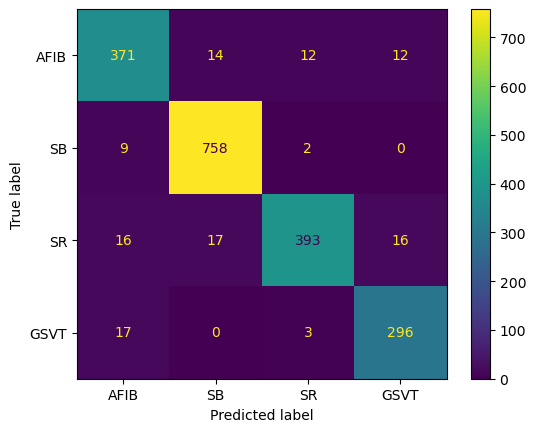

,Rhythm Group,ACC,Recall,Precision,F1-score,specificity
0,AFIB,0.958678,0.907090,0.898305,0.902676,0.972495
1,SB,0.978306,0.985696,0.960710,0.973042,0.973436
2,SR,0.965909,0.889140,0.958537,0.922535,0.988621
3,GSVT,0.975207,0.936709,0.913580,0.925000,0.982716
4,macro avg,NaN,0.929659,0.932783,0.930813,NaN
5,micro avg,NaN,0.939050,0.939050,0.939050,NaN
6,weighted avg,NaN,0.939050,0.939337,0.938804,NaN


In [13]:
evaluation_test = evaluation_test(y_test,result_test)
df_evaluation_test = pd.DataFrame(data=evaluation_test,columns=["Rhythm Group","ACC","Recall","Precision","F1-score","specificity"])
df_evaluation_test

In [14]:
df_evaluation_test.to_csv("../Result/SVM_12_lead_test_mean.csv")